In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import lsst.syseng.throughputs as st
from lsst.sims.photUtils import PhotometricParameters, Sed
import galsim
import matplotlib.pyplot as plt

### We use Eq (6) in LSE-40. With the baseline system as defined by syseng_throughput (including hardware & atmosphere), We can easily map a source magnitude to a source count. This is not affected by seeing. Seeing comes into play because it determines how far to spread the total source count.

In [2]:
#The 3 fiducial atmosphere as defined by SRD Table 9.
fwhms = {'25':.44, '50':.60, '75':.80}

# full_well for a 30s visit, in e-
full_well = 150e3  #typical for e2v sensors. ITL is typically 200k. We try to be conservative and use the smaller.
bias_offset = 45e3
bias_offset_subtract = 0 #According to Steve R. and Aaron R., this should not be a factor

## We first determine what fraction of the flux will be in the center/brightest pixel
### Here for the atmosphereric PSF shape, we have assumed Kolmogorov. Currently Galsim doesn't provide Von Karman atmosphere profile. The difference between the two profiles, while the FWHM is the same, is expected to be small.

[0.08276032 0.0577153  0.03927402]


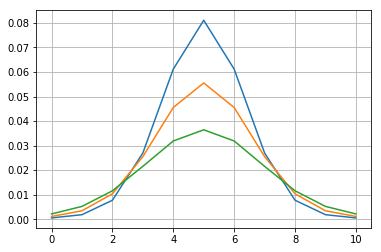

In [3]:
stamp_size = 11
pixel_scale = 0.2
ratio = np.zeros(3)
optics = galsim.Gaussian(fwhm=0.4)
for i, p in enumerate(fwhms):
    atm = galsim.Kolmogorov(fwhm=fwhms[p])
    psf = galsim.Convolve(atm, optics)
    img = galsim.ImageD(stamp_size, stamp_size, scale=pixel_scale)
    psf = psf.withFlux(1) #unit flux
    psf.drawImage(image=img)
    ratio[i] = img.array.max()/np.sum(img.array)
    plt.plot(img.array[5,:])
print(ratio)
plt.grid()

### Baseline LSST system, as defined in syseng_throughput

In [4]:
defaultDirs = st.setDefaultDirs()
hardware, system = st.buildHardwareAndSystem(defaultDirs)

### Default photometric parameters, as used in standard m5 calculations

In [5]:
exptime=15 
nexp=2
readnoise=8.8 
othernoise=0 
darkcurrent=0.2
effarea=np.pi*(6.423/2*100)**2
X=1.0

# PhotometricParameters object for standard m5 calculations.
photParams_std = PhotometricParameters(exptime=exptime, nexp=nexp,
                                           gain=1.0, effarea=effarea, readnoise=readnoise,
                                           othernoise=othernoise, darkcurrent=darkcurrent)

### Let's make sure we can reproduce standard m5 results

In [6]:
m5 = st.makeM5(hardware, system, darksky=None, 
                      exptime=exptime, nexp=nexp, readnoise=readnoise, othernoise=othernoise, darkcurrent=darkcurrent,
                      effarea=effarea, X=1.0)

In [7]:
m5

,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,0.92,0.80824,22.960730,80.840573,27.009181,0.035837,0.057997,0.522669,0.038185,23.165597,0.576230,0.362984,23.849238,550.932990,23.9,23.4
g,0.87,0.76714,22.257758,411.094794,28.399288,0.128938,0.154358,0.195371,0.038743,24.447490,0.176182,0.093056,24.840316,795.628429,25.0,24.6
r,0.83,0.73426,21.196590,818.797145,28.177407,0.105106,0.115690,0.104170,0.038990,24.467511,0.096081,0.047725,24.380855,990.243723,24.7,24.3
i,0.80,0.70960,20.477419,1173.487799,27.879556,0.079889,0.085493,0.073607,0.039101,24.363045,0.068928,0.033121,23.956774,1112.330543,24.0,23.6
z,0.78,0.69316,19.599578,1782.992383,27.481805,0.055384,0.057871,0.047694,0.039235,24.201828,0.046435,0.021447,23.384125,1306.751554,23.3,22.9
y,0.76,0.67672,18.610405,2371.023361,26.687500,0.026648,0.030944,0.162291,0.039311,23.759692,0.035324,0.015804,22.475605,1451.707778,22.1,21.7


### Set up the dataframe

In [8]:
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
properties = ['SatLim25', 'SatLim50','SatLim75']
d = pd.DataFrame(index=filterlist, columns=properties, dtype='float')

### Calculate the saturation limits

In [9]:
for f in system:
    flatsource = Sed()
    flatsource.setFlatSED(wavelen_min=system[f].wavelen_min, wavelen_max=system[f].wavelen_max,
                              wavelen_step=system[f].wavelen_step)
    adu = flatsource.calcADU(system[f], photParams=photParams_std)
    
    for i,p in enumerate(fwhms):
        adu0 = adu*ratio[i]
        key = 'SatLim%s'%p
        #because setFlatSED() assumes a m=0 star
        # we use gain=1.0, so adu = number of e-
        # we also get rid of skycounts from each pixel. This has miminal effect on results
        d[key].loc[f] = np.log10(adu0/(full_well-m5.skyCounts.loc[f]-bias_offset_subtract))/2*5
        # The above can also be obtained this way, 
        # (but flatsource has to be re-initialized for each calculation)
        # Scale fnu so that adu0 is equal to full well.
        #flatsource.fnu = flatsource.fnu * (full_well/adu0)
        #d[key].loc[f] = flatsource.calcMag(system[f])

In [10]:
d.join(m5)

,SatLim25,SatLim50,SatLim75,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,15.056897,14.665569,14.247605,0.92,0.80824,22.960730,80.840573,27.009181,0.035837,0.057997,0.522669,0.038185,23.165597,0.576230,0.362984,23.849238,550.932990,23.9,23.4
g,16.449399,16.058071,15.640106,0.87,0.76714,22.257758,411.094794,28.399288,0.128938,0.154358,0.195371,0.038743,24.447490,0.176182,0.093056,24.840316,795.628429,25.0,24.6
r,16.230481,15.839153,15.421189,0.83,0.73426,21.196590,818.797145,28.177407,0.105106,0.115690,0.104170,0.038990,24.467511,0.096081,0.047725,24.380855,990.243723,24.7,24.3
i,15.935214,15.543886,15.125921,0.80,0.70960,20.477419,1173.487799,27.879556,0.079889,0.085493,0.073607,0.039101,24.363045,0.068928,0.033121,23.956774,1112.330543,24.0,23.6
z,15.541918,15.150590,14.732626,0.78,0.69316,19.599578,1782.992383,27.481805,0.055384,0.057871,0.047694,0.039235,24.201828,0.046435,0.021447,23.384125,1306.751554,23.3,22.9
y,14.751930,14.360602,13.942638,0.76,0.67672,18.610405,2371.023361,26.687500,0.026648,0.030944,0.162291,0.039311,23.759692,0.035324,0.015804,22.475605,1451.707778,22.1,21.7


### For making the plot below, we only use FWHM of atmosphere of 0.6 arcsec, so that the PSF is 0.7 arcsec in FWHM

In [11]:
pRatio = ratio[properties.index('SatLim50')]
colors = ['blue', 'green', 'red', '0.75', '0.50', '0.25']
d1 = pd.DataFrame(index=filterlist, columns=['SatLimFromPlot'], dtype='float')

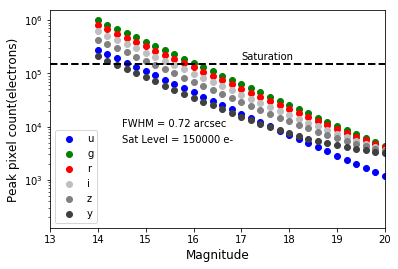

In [15]:
for i,f in enumerate(filterlist):
    mags = []
    npeaks = []
    flatsource = Sed()
    flatsource.setFlatSED(wavelen_min=system[f].wavelen_min, wavelen_max=system[f].wavelen_max,
                              wavelen_step=system[f].wavelen_step)
    adu = flatsource.calcADU(system[f], photParams=photParams_std)
    adu0 = adu*pRatio #a m=0 start produces this adu0 in the center pixel
    for m in range(31):
        mag = 14.0 + 0.2 * m
        mags.append(mag)
        npeak = adu0*10**(-mag/2.5)+m5.skyCounts.loc[f]+bias_offset_subtract
        npeaks.append(npeak)
    plt.scatter(mags, npeaks, label=f, color=colors[i])
    d1.SatLimFromPlot.loc[f] = mags[np.argmax(np.array(npeaks)<full_well)]
plt.plot([13.0,20.0],[full_well, full_well], ls = '--', lw = 2, color='black')
plt.text(17.0, full_well*1.20, "Saturation", color = 'black')
plt.text(14.5, 10000, "FWHM = %.2f arcsec"%(np.sqrt(fwhms['50']**2+0.4**2)), color = 'black')
plt.text(14.5, 5000, "Sat Level = %d e-"%full_well, color = 'black')
plt.legend()
plt.yscale('log')
plt.xlim(13.0,20.0)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Peak pixel count(electrons)', fontsize=12)
plt.savefig('Peak_count_by_band_13Dec19.pdf')

In [16]:
d1.join(d)

,SatLimFromPlot,SatLim25,SatLim50,SatLim75
u,14.8,15.056897,14.665569,14.247605
g,16.2,16.449399,16.058071,15.640106
r,16.0,16.230481,15.839153,15.421189
i,15.6,15.935214,15.543886,15.125921
z,15.2,15.541918,15.150590,14.732626
y,14.4,14.751930,14.360602,13.942638


#### If we subtracted the bias offset, how much does it reduce the dynamic range (in magnitude)?

In [17]:
np.log10(full_well/(full_well-bias_offset))*2.5

0.3872548999643579